In [1]:
__author__ = 'nvd'
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
s = json.load(open(os.getenv('PUI2015')+'/plotformat.json'));
plt.rcParams.update(s)
%pylab inline

#import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import pysal as ps
import mplleaflet

Populating the interactive namespace from numpy and matplotlib


C:\Users\Neil\Anaconda\lib\site-packages\matplotlib\__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import zipfile

years = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', 
         '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']
for i in years:
    fname = os.getenv ('PUI2015')+'/zbp'+i+'totals.zip'
    zf = zipfile.ZipFile(fname)
    name = 'df'+i
    our_text_file = zf.open('zbp'+i+'totals.txt')
    globals()[name] = pd.read_csv(our_text_file)

In [3]:
geodata = gpd.read_file(os.getenv ('PUI2015')+
                        '/nyc-zip-code-tabulation-areas-polygons.geojson')
geodata1 = gpd.read_file(os.getenv ('PUI2015')+
                        '/nyc-zip-code-tabulation-areas-polygons.geojson')

In [4]:
geodata['zip'] = geodata['postalCode']
geod= pd.DataFrame({'zip':geodata['zip'].astype(float)}).drop_duplicates()
geod.head()
finaldf = geod

In [5]:
for i in years:
    #array = 'data'+i
    name='df'+ i 
    dataframe = globals()[name]
    dataframe.head()
    if i == '98' or i == '99' or i == '00' or i == '01' or i == '02':
        dataframe = dataframe[['ZIP','EST']]
        #dataframe['est'+i] = dataframe['EST']
        dataframe.columns = ['zip', 'est'+i]
        newdf = pd.merge(geod,dataframe, on = 'zip')
        #globals()[array] = globals()[dataframe].as_matrix()
    else:
        dataframe = dataframe[['zip', 'est']]
        #dataframe['est'+i] = dataframe['est']
        dataframe.columns = ['zip', 'est'+i]  
        newdf = pd.merge(geod,dataframe, on = 'zip')
        
        #globals()[array] = globals()[dataframe].as_matrix()
    finaldf['est'+i] = newdf['est'+i]

In [6]:
finaldf.head()

,zip,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est04,est05,est06,est07,est08,est09,est10,est11,est12,est13
0,11372,1229,1236,1292,1309,1351,1376,1409,1408,1463,...,1554,1539,1527,1545,1538,1572,1629,1647,1724,1759
1,11004,194,188,176,192,194,186,189,204,214,...,226,225,226,238,227,233,229,222,241,241
2,11040,1422,1414,1335,1344,1344,1350,1350,1341,1398,...,1406,1441,1454,1488,1503,1475,1494,1488,1510,1539
3,11426,326,219,209,198,203,217,213,217,207,...,221,226,226,228,226,237,248,256,266,258
4,11365,492,476,483,522,509,519,553,574,574,...,599,604,608,617,616,628,643,677,679,714


In [7]:
shape(finaldf)

(247, 21)

In [8]:
est_time_array = finaldf.as_matrix()

badindex = []
for i,est in enumerate(est_time_array):
    if np.isnan(est).any():
        badindex.append(i)
        
clean_array = np.delete(est_time_array, badindex, 0)

np.shape(clean_array)

(224L, 21L)

In [9]:
zips=[]
for i in range(224):
    new = clean_array[i][1:]
    zips.append(clean_array[i][0])
    array_mean = np.mean(new)
    array_std = np.std(new)
    for i in range(len(new)):
        new[i] = (new[i]-array_mean)/array_std
    clean_array[i][1:] = new

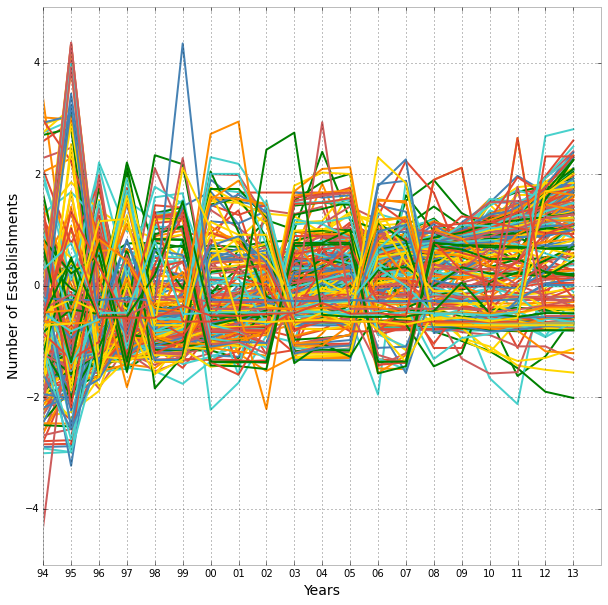

In [10]:
plt.figure(figsize=(10, 10), dpi=200)
s = []
for i in range(224):
    ax = plt.plot(range(20), clean_array[i][1:])
    s.append(clean_array[i][1:])
#we used transpose to get the time on the x axis
plt.ylabel('Number of Establishments', fontsize = 14)
plt.xlabel('Years', fontsize = 14)
plt.xticks(range(20), years);
s=np.array(s)

                 Plot of the different time series after normalization

C:\Users\Neil\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


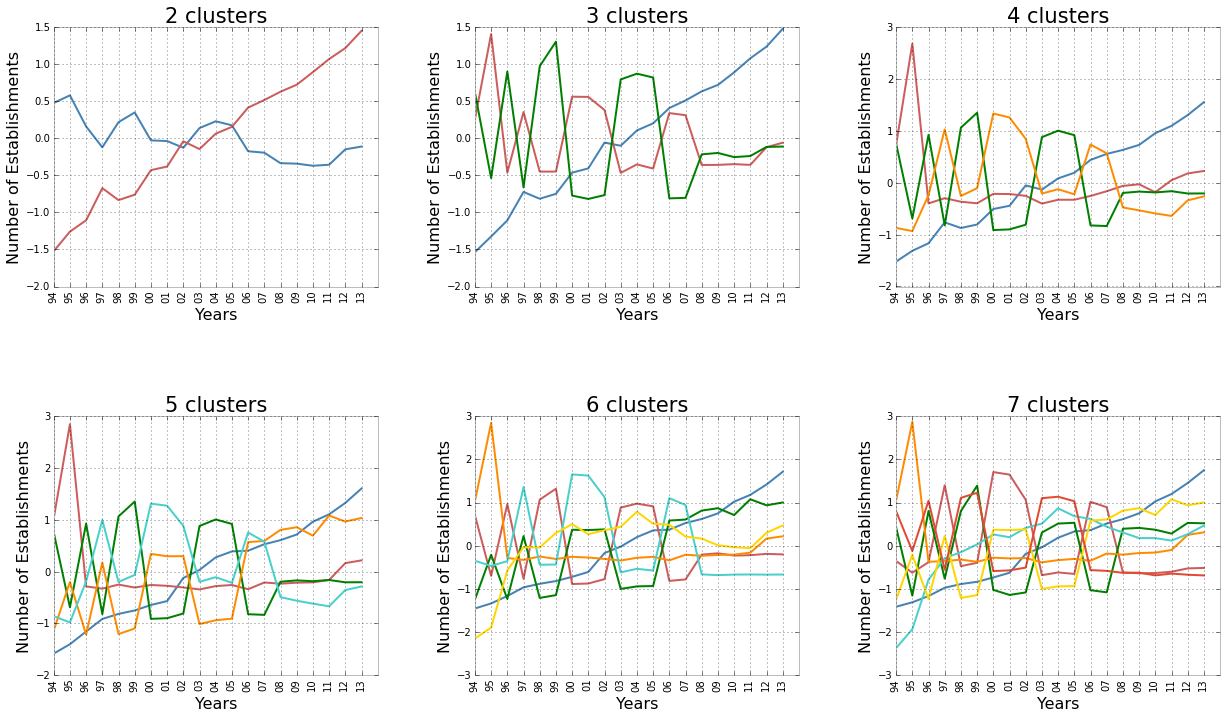

In [11]:
from sklearn.cluster import k_means
plt.figure(figsize=(18, 18), dpi=200)
p = 1
for i in range(6):
    n = i+2
    est=k_means(s,n_clusters = n)
    plt.subplot(2, 3, p)
    p += 1
    plt.plot(range(20), transpose(est[0]))
    plt.title(str(n)+' clusters', fontsize = 21)
    plt.ylabel('Number of Establishments', fontsize = 16)
    plt.xlabel('Years', fontsize = 16)
    plt.xticks(range(20), years, rotation = 90);
    plt.legend()
plt.subplots_adjust(wspace=.3, hspace=0.5, left=0, right=0.9, top=0.5, bottom=0)

                                 Plots of the centroids of the various clusters using K-means

#### The best clustering seems to be 4 to 6 clusters where most of the different patterns are captured.

Further the clustering of 5 will be used.

In [12]:
with_zip=pd.DataFrame()
with_zip['zip']=zips

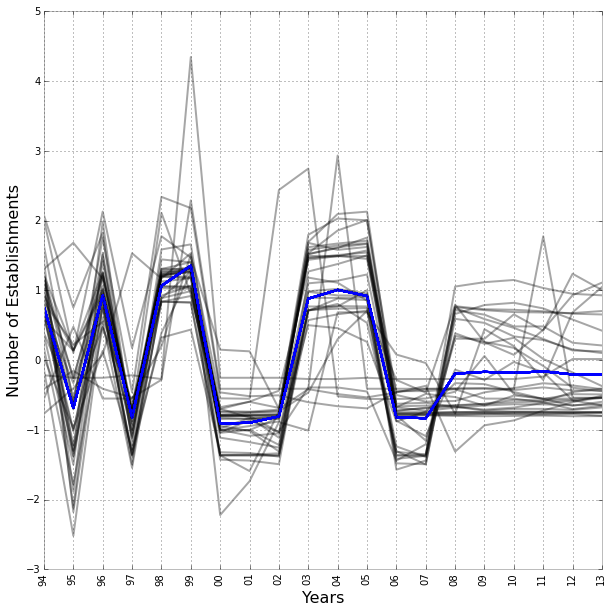

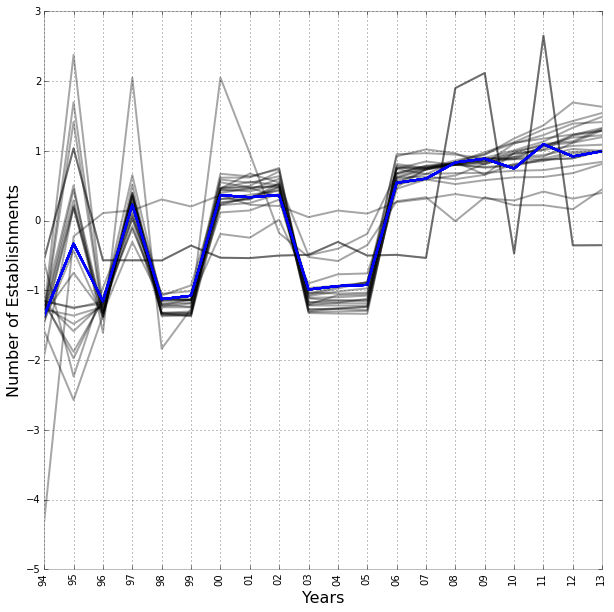

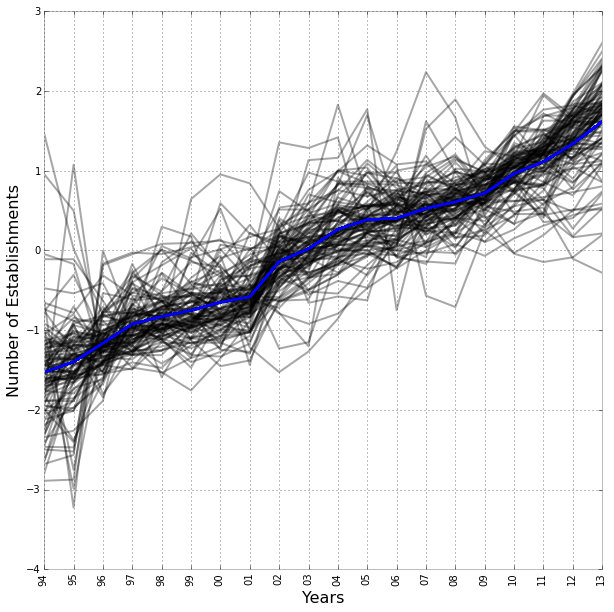

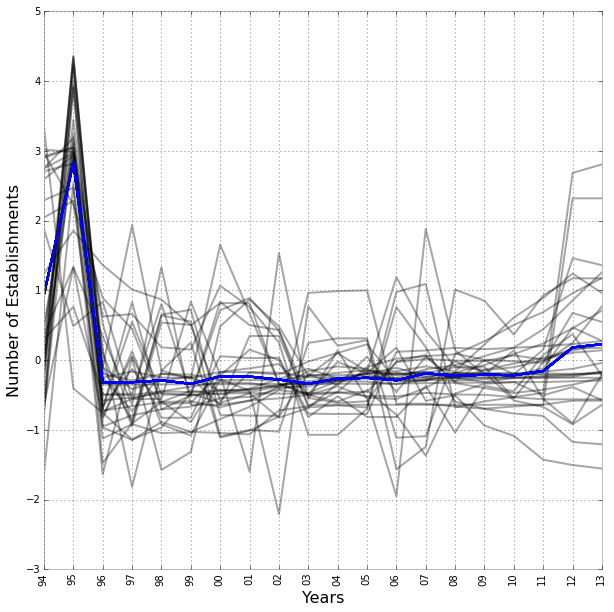

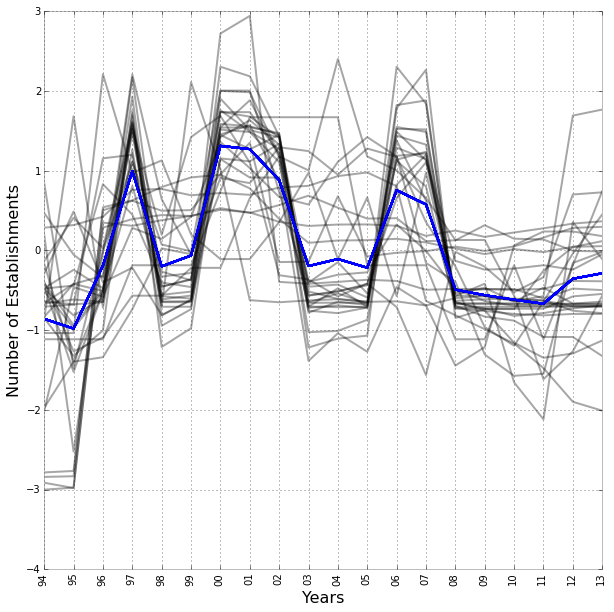

In [13]:
est = k_means(s,n_clusters=5)
with_zip['cluster'] = est[1]
for m in range(5):
    i = 0
    fig0 = plt.figure(figsize=(10,10));
    ax0 = fig0.add_subplot(1,1,1);
    for j in est[1]:
        if j==m:
            ax0.plot(range(20),s[i],c='k', alpha = 0.35)
            ax0.plot(range(20),est[0][j],c='b')
            plt.ylabel('Number of Establishments', fontsize = 16)
            plt.xlabel('Years', fontsize = 16)
            plt.xticks(range(20), years, rotation = 90);
        i = i+1

                 Plots of each cluster with its comprising timeseries

In [14]:
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters=5, compute_full_tree=True).fit(s)

In [15]:
with_zip['cluster2']=agc.labels_

In [16]:
geodata1['zip'] = geodata1['postalCode'].astype(float)
clusters = geodata1.join(with_zip,rsuffix='zip',how='inner')

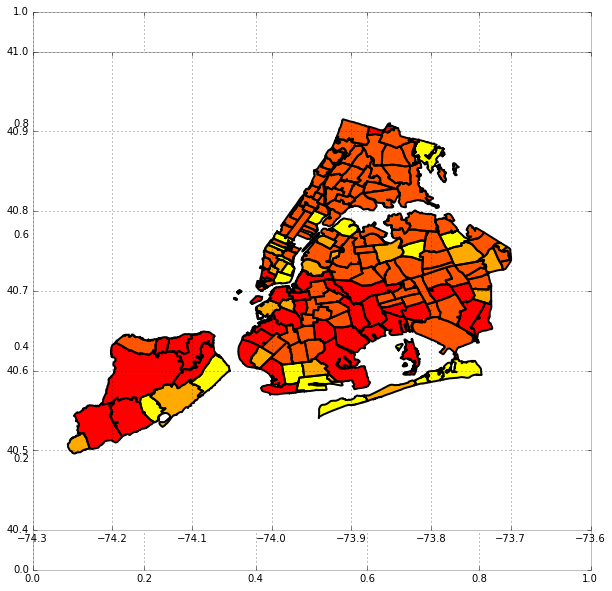

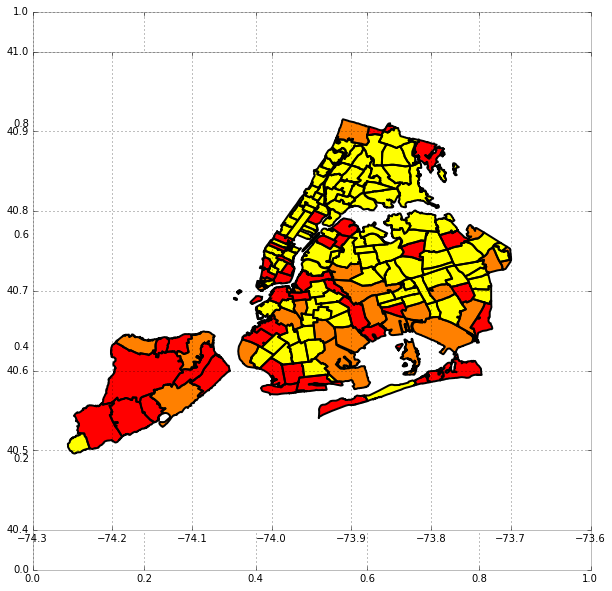

In [17]:
f, ax = plt.subplots(1, figsize=(10,10))
clusters.plot(column='cluster', scheme='QUANTILES', alpha=1, colormap='autumn')
f, ax = plt.subplots(1, figsize=(10,10))
clusters.plot(column='cluster2', scheme='QUANTILES', alpha=1, colormap='autumn')